## Tiny Imagenet

### Imports and setup 

In [1]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>7: fc.defaults.cpus=7

### Data processing 

In [4]:
path_data = Path('/home/datasets/data')
path_data.mkdir(exist_ok=True)
path_to_dataset = path_data / 'tiny-imagenet-200'
path_to_dataset.mkdir(exist_ok=True)

In [5]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path_data.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive(path_data/'tiny-imagenet-200.zip', path_data)

In [6]:
bs = 512

For this dataset the class is contained in the file parent's parent folder name

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return self.files[i],Path(self.files[i]).parent.parent.name

In [8]:
path_to_dataset

Path('/home/datasets/data/tiny-imagenet-200')

In [9]:
tds = TinyDS(path_to_dataset/'train')

In [10]:
tds[0]

('/home/datasets/data/tiny-imagenet-200/train/n03584254/images/n03584254_251.JPEG',
 'n03584254')

In [11]:
path_anno = path_to_dataset/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [12]:
anno['val_0.JPEG']

'n03444034'

In [13]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [14]:
vds = TinyValDS(path_to_dataset/'val')

In [15]:
vds[0]

('/home/datasets/data/tiny-imagenet-200/val/images/val_5461.JPEG', 'n04486054')

In [16]:
len(tds), len(vds)

(100000, 10000)

In [17]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

Generate indecies and lookups for the classes

In [18]:
id2str = (path_to_dataset/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [19]:
id2str[0:3]

['n02124075', 'n04067472', 'n04540053']

In [20]:
str2id['n02124075']

0

Define the means and std of the dataset

In [21]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

Create transforms to read and normalize x and to convert the string value of the class to an integer

In [22]:
def tfmx(file_path):
    """ Read an image as a tensor based upon the path and then normalize.
    """

    img = read_image(file_path, mode=ImageReadMode.RGB)/255
    return (img-xmean[:,None,None])/xstd[:,None,None]

In [23]:
def tfmy(y): 
    """ Convert label to index and then to a tensor
    """
    return tensor(str2id[y])

Create transforms for train and valid datasets

In [24]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [25]:
xi,yi = tfm_tds[0]
id2str[yi]

'n03584254'

In [26]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

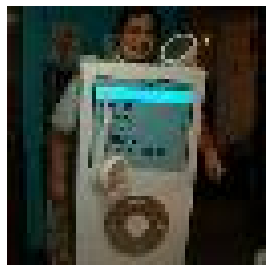

In [27]:
show_image(denorm(xi));

Create dataloader for training

In [28]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=7)

In [29]:
xb,yb = b = next(iter(dltrn))

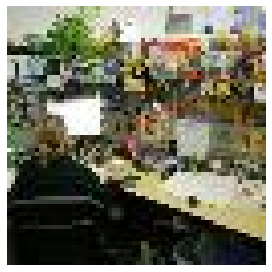

In [30]:
show_image(denorm(xb[0]));

Generate a dictionary to map the class names to real world labels

In [31]:
all_synsets = [o.split('\t') for o in (path_to_dataset/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [32]:
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'desk, turnstile, cliff dwelling, pay-phone, magnetic compass, plate, walking stick, Egyptian cat, ladybug, brass, sock, Egyptian cat, teddy, ice cream, poncho, golden retriever, turnstile, monarch, dragonfly, umbrella'

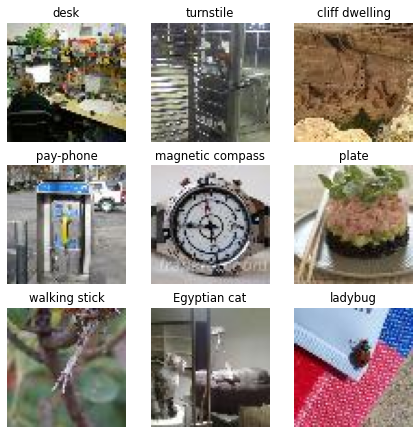

In [33]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [34]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=7))

### Basic Model 

In [35]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [36]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [37]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [38]:
nfs = (32,64,128,256,512,1024)


In [39]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
#     layers += [ResBlock(nfs[0], nfs[0], ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

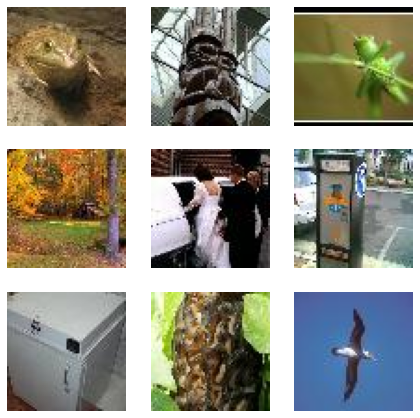

In [40]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [46]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [41]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [42]:
lr_cbs = [DeviceCB(), augcb, MixedPrecision(), ProgressCB()]

In [43]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
#learn.lr_find()

In [44]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

Rerun after restarting notebook

In [107]:
epochs = 25
lr = 0.02
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

In [108]:
epochs = 25
lr = 0.005
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.081,4.657,0,train
0.148,4.075,0,eval
0.191,3.876,1,train
0.212,3.668,1,eval
0.250,3.496,2,train
0.260,3.339,2,eval
0.290,3.225,3,train
0.288,3.181,3,eval
0.326,2.992,4,train
0.315,3.000,4,eval


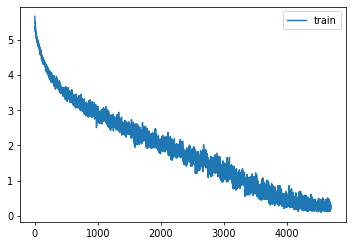

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, '/home/models/inettiny-basic-25')

In [100]:
norm = partial(nn.BatchNorm2d, eps=1.e-4)

In [101]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=norm, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
#     layers += [ResBlock(nfs[0], nfs[0], ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200, eps=1.e-4)]
    return nn.Sequential(*layers).apply(iw)

In [102]:
epochs = 25
lr = 0.02
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

In [96]:
norm = partial(nn.BatchNorm2d, eps=1.e-4)

### Deeper 

In [45]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    """ This is used to define the res blocks after the first block until the pooling layers.
    The first layer will have ni filters.  The remaining will have nf input and output filters
    Each resblock created will have two conv layers
    
    args
        n_bl: number of blocks to create
        ni: number of input filters
        nf, number of filters
        stride:
        ks: kernel size
        act: activation
        norm
    """
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [46]:
# Number of resblocks per downsampling layer.  In the last model there were 5 resblocks, and so this
# is significantly deeper with 9
nbks = (3,2,2,1,1)

In [47]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    """
    The first block will have one resblock with a kernel of 5.  In the last model there was just one conv layer
    at the start. In addition there is no downsampling of this layer
    
    In the last model the number of blocks was defined by the list of filters (nfs).  In this case the resblocks
    creates multiple of the blocks with the same parameters
    
    The maintain the channels at the correct level the stride is set to 1 for all but the last element of
    one of res_block groups
    
    args
        act: activation function
        nfs: list of number of filters
        nbks: list of number of blocks
        norm: normalization function
        drop: value to use for dropout layers
    """
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

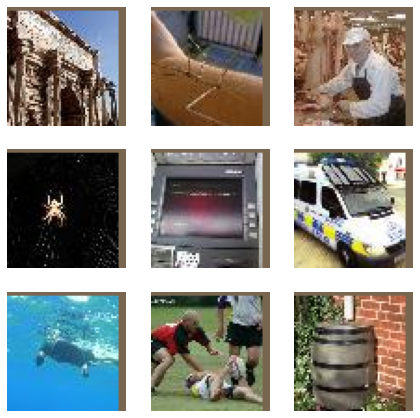

In [48]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [49]:
nfs

(32, 64, 128, 256, 512, 1024)

In [50]:
learn.summary()

Tot params: 21426800; MFLOPS: 710.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 3, 64, 64)|(512, 32, 64, 64)|28320|115.1|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|206016|209.7|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|525952|134.2|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|2100480|134.2|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


This model requires twice the MFLOPs of the earlier model and has slightly more parameters

In [51]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [ ]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [53]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.082,4.555,0,train
0.126,4.107,0,eval
0.206,3.656,1,train
0.203,3.620,1,eval
0.269,3.248,2,train
0.258,3.320,2,eval
0.314,2.975,3,train
0.280,3.279,3,eval
0.349,2.779,4,train
0.313,3.089,4,eval


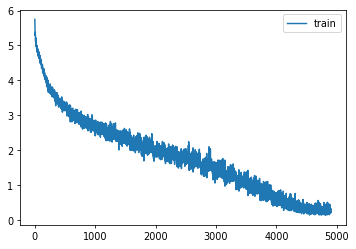

In [54]:
learn.fit(epochs)

In [55]:
torch.save(learn.model, '/home/models/inettiny-custom-25')

### More Augmentation 

In [39]:
aug_tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     T.TrivialAugmentWide())

norm_tfm = T.Normalize(xmean, xstd)
erase_tfm = RandErase()

Note that TrivialAugmentWide requires a PIL image and so the transforms will need to be
modified to work with that.  Also note that doing this augmentation at batch level doesn't work as well as doing it for individual images, hence again it is necessary to change the data loader.

In the transform function the rand erase works over the 0-1 range and so needs to happen after the normalization phase.  

In this model all of the augmentation is happening in the dataloader

In [40]:
from PIL import Image

In [41]:
def tfmx(x, aug=False):
    x = Image.open(x).convert('RGB')
    if aug: x = aug_tfms(x)
    x = TF.to_tensor(x)
    x = norm_tfm(x)
    if aug: x = erase_tfm(x[None])[0]
    return x

In [42]:
tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [43]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=7))

The functions below are a way of implementing pre-activation resnets.
In the original resnet the conv block has two layers and the second has no activations.  Also the identity path has activations and hence is not a pure identity path

To modify this the paper "Identity Mappings in Deep Residual Networks", which will allow a straightforward path through.
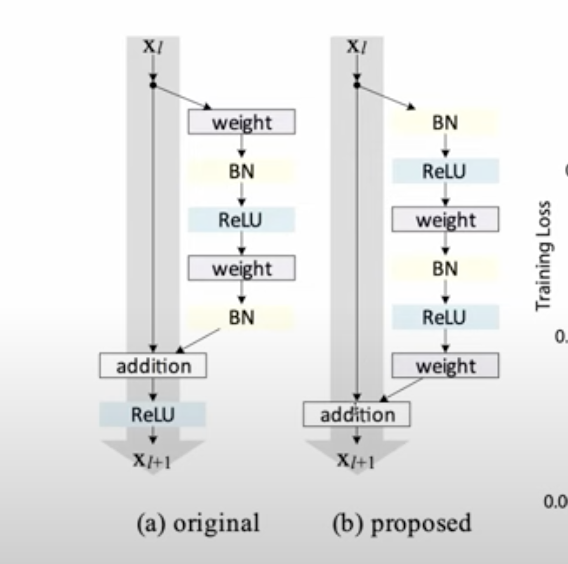

To implement this we re-define the conv to change the order and to apply the activations to both layers. We also have no activation on the forward method where we combine the convs and the id path


In [45]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def get_dropmodel(act=act_gr, nfs=nfs, nbks=(4,3,3,2,1), norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

Now create a model to implemebt the above.  In this case the number of blocks hs been expanded

In [54]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [46]:
def get_model(): return get_dropmodel(nbks=(4,3,3,2,1), drop=0.1)

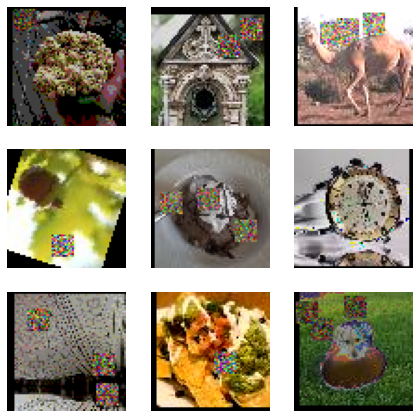

In [49]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [50]:
learn.summary()

Tot params: 27675600; MFLOPS: 907.6


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|280128|285.2|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|821632|209.7|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|3281664|209.7|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|8395264|134.2|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|GeneralRelu|(512, 1024, 2, 2)|(512, 1024, 2, 2)|0|0.0|
|BatchNorm2d|(512, 1024, 2, 2)|(512, 1024, 2, 2)|2048|0.0|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [55]:
epochs = 50
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.022,5.080,0,train
0.033,4.925,0,eval
0.042,4.811,1,train
0.064,4.509,1,eval
0.075,4.507,2,train
0.106,4.221,2,eval
0.110,4.223,3,train
0.140,4.045,3,eval
0.144,3.965,4,train
0.139,4.144,4,eval


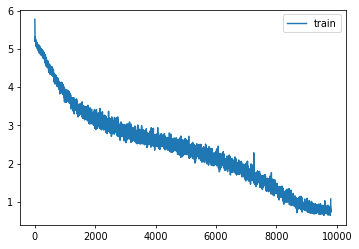

In [56]:
learn.fit(epochs)

In [57]:
torch.save(learn.model, '/home/models/inettiny-trivaug-50')